In [9]:
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
import os
import numpy as np
import csv
from lmfit.models import QuadraticModel, LorentzianModel

In [3]:
parent_dir = '/home/sethshj/Programs/M2/10_25_2024/'

In [4]:
transition_metals = [
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn'
]

matching_files = []

# Loop through each transition metal and search for files that match the pattern
for metal in transition_metals:
    # Use glob to search for files where the transition metal appears after the underscore
    pattern = f'{parent_dir}**/**_{metal}/Corvus.cfavg.xes.out'
    matching_files.extend(glob.glob(pattern, recursive=True))

print(matching_files)

['/home/sethshj/Programs/M2/10_25_2024/LaScSb/LaScSb_Sc/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/SrTiN2/SrTiN2_Ti/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/TiNiAs/TiNiAs_Ti/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/CsBaVS4/CsBaVS4_V/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/ErVO4/ErVO4_V/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/VPO5/VPO5_V/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/CrB/CrB_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/CrF4/CrF4_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/MgCrO4/MgCrO4_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/SrCrF4/SrCrF4_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/MnBr2/MnBr2_Mn/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/MnPO4/MnPO4_Mn/Corvus.cfavg.xes.out', '/home/sethshj/Programs/M2/10_25_2024/NaFeF4/NaFeF4_Fe/Corvus.cfavg.xes.out', '/home

In [5]:


def xes_integrated_abs_difference(data_1, data_2):
    ''' 
    Calculate the integrated absolute difference of Δμ(E) for data_1 and data_2.

    Data 1 and 2 have orthogonal polarizations.

    Parameters:
    data_1 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 1.
    data_2 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 2.

    Returns:
    difference (float): The integrated absolute difference of Δμ(E) between the two datasets.
    '''
    # Calculate the absolute difference of Delta mu(E)
    abs_difference = np.abs(data_1 - data_2)

    # Integrate the absolute difference over the energy range
    integrated_abs_difference = np.sum(abs_difference)

    return integrated_abs_difference


def xes_average(data_1, data_2, data_3):
    '''
    Calculates the integral of the average of 3 orthogonally polarized XES spectra.

    Parameters:
    data_1 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 1.
    data_2 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 2.
    data_3 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 3.

    Return:
    integrated_average (float): The integral of the average of the 3 spectra.
    '''
    # Calculate the average of Delta mu(E) values
    average_delta_muE = (data_1 + data_2 + data_3) / 3

    # Integrate the average Delta mu(E) over the energy range
    integrated_average = np.sum(average_delta_muE)

    return integrated_average


def anisotropy_parameter(xes_difference, xes_average):
    '''
    Calculate the anisotropy parameter, which is the quotient of the XES difference and the XES average.

    Parameters:
    xes_difference (float): The integrated absolute difference of Δμ(E).
    xes_average (float): The integral of the average of the 3 spectra.

    Returns:
    float: The anisotropy parameter.
    '''
    if xes_average == 0:
        raise ValueError(
            "The xes_average must not be zero to avoid division by zero.")

    return xes_difference / xes_average


def anisotropy_matrix(data_x, data_y, data_z):
    '''
    Calculate a 3x3 anisotropy matrix where each entry represents the anisotropy parameter 
    for the difference between two datasets divided by the average of all three datasets.

    Parameters:
    data_x (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization x.
    data_y (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization y.
    data_z (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization z.

    Returns:
    numpy.ndarray: A 3x3 anisotropy matrix.
    '''
    # Calculate the XES average of all three datasets
    xes_avg = xes_average(data_x, data_y, data_z)

    # Initialize a 3x3 matrix
    anisotropy_mat = np.zeros((3, 3))

    # Define the pairs for which to calculate the differences
    pairs = [(data_x, data_y), (data_x, data_z), (data_y, data_z)]

    # Fill the anisotropy matrix with the anisotropy parameters
    for i, (data1, data2) in enumerate(pairs):
        diff = xes_integrated_abs_difference(data1, data2)
        anisotropy_mat[i][(i+1) % 3] = anisotropy_parameter(diff, xes_avg)
        anisotropy_mat[(i+1) % 3][i] = anisotropy_mat[i][(i+1) %
                                                         3]  # Symmetric entries

    return anisotropy_mat

In [6]:
def read_data(file):
    return np.loadtxt(file)

output_csv = f'{parent_dir}anisotropy_data.csv'

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as file_out:
    csv_writer = csv.writer(file_out)
    
    # Write the header row
    csv_writer.writerow(['parent_dir', 'm00', 'm01', 'm02', 'm10', 'm11', 'm12', 'm20', 'm21', 'm22'])
    
    # Loop through each matching file and process the data
    for file in matching_files:
        data = read_data(file)
        data_x = data[:, 1]
        data_y = data[:, 2]
        data_z = data[:, 3]
        
        # Calculate the anisotropy matrix (3x3)
        anisotropy_mat = anisotropy_matrix(data_x, data_y, data_z)
        
        # Get the parent directory name
        parent_dir = os.path.basename(os.path.dirname(file))
        
        # Flatten the 3x3 matrix into a single row (list)
        flattened_matrix = anisotropy_mat.flatten().tolist()
        
        # Prepend the parent_dir to the flattened matrix row
        row = [parent_dir] + flattened_matrix
        
        # Write the row to the CSV
        csv_writer.writerow(row)

print(f"Data has been written to {output_csv}")
    

Data has been written to /home/sethshj/Programs/M2/10_25_2024/anisotropy_data.csv


#PROBABILITY DISTRIBUTION

In [18]:
def LORENTZIAN_MODEL(center, num, sigma= 0.15, amp= 4000):
    """We know we want to set up lots of Lorentzians. Here is a function that sets one up fast.
    The function will stay in all caps unlike regular functions because I'm too lazy to change it after the
    first time I wrote this. This will be filled with data at the bottom of the cell"""

    model = LorentzianModel(prefix= num)
    modelparams = model.make_params()
    modelparams[num + 'center'].set(center)
    modelparams[num + 'amplitude'].set(amp)
    modelparams[num + 'sigma'].set(sigma, min=0)
    return model, modelparams

def central_limit_theorem_slope_change(independent_column, dependent_column)->list:
    """This takes two columns of data (Corvus.cfavg.out, XMU.dat, or any other spectral data in two columns)
    and conducts the central limit theorem. We store the zero points and put them in a list for our model guesser."""
    
    zipped_data = list(zip(independent_column, dependent_column))
    
    slope_changes = []
    
    for i in range(1, len(zipped_data) - 1):
        x1, y1 = zipped_data[i-1]  
        x2, y2 = zipped_data[i]    
        x3, y3 = zipped_data[i+1]
        
        slope1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else 0
        slope2 = (y3 - y2) / (x3 - x2) if (x3 - x2) != 0 else 0
        

        if slope1 > 0 and slope2 < 0:
            slope_changes.append(x2)  # store the point where the change occurs. We only want the x (eV). If you want both poits, insert (x2,y2) instead
    
    return slope_changes

#BigModel= QuadraticModel(label= 'Background')
#AllParams= BigModel.make_params(a=0, b=0, c=0)

for file in matching_files:
    data = read_data(file)
    energy = data[:, 0]
    data_x = data[:, 1]
    data_y = data[:, 2]
    data_z = data[:, 3]
    data_isotropic = data[:, 4]

slope_changes_x_pol = central_limit_theorem_slope_change(data[:, 0],data[:, 1])
#slope_changes_y_pol = central_limit_theorem_slope_change(data[: 0],data[: 2])
#slope_changes_z_pol = central_limit_theorem_slope_change(data[: 0],data[: 3])
#slope_changes_isotropic = central_limit_theorem_slope_change(data[: 0],data[: 4])

print(slope_changes_x_pol)
AllParams = None
BigModel = []

for i, cen in enumerate(slope_changes_x_pol):
    model, modelparams = LORENTZIAN_MODEL(cen, 'data%d_' % (i+1) )
    AllParams = None
    BigModel = model
    AllParams.update(modelparams)

calculation = BigModel.eval(AllParams, x= data_x)
calculation_fit = BigModel.fit(data[:, 0], AllParams, x= data_x)
calculationVariables = calculation_fit.eval_components()

print(calculation_fit.fit_report(min_correl=0.5))

plt.plot(energy, data_x, label = 'X Polarization')
plt.plot(energy, calculation_fit.best_fit, label='best fit')
for name, comp in calculationVariables.items():
    plt.plot(data[:, 0], comp, '--', label=name)
plt.legend()
plt.title('Lines of best fit')
plt.xlabel('Energy (eV)')
plt.ylabel('Relative Intensity (arb. units)')
plt.show()
myfig = plt.figure(figsize=(12,9)) 

[9640.727281687898, 9647.727281687796, 9659.327281687627]


AttributeError: 'NoneType' object has no attribute 'update'

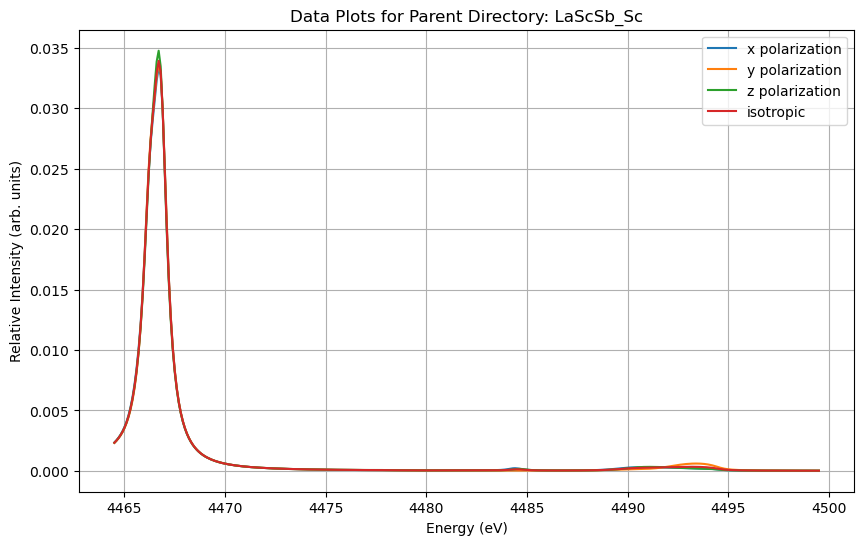

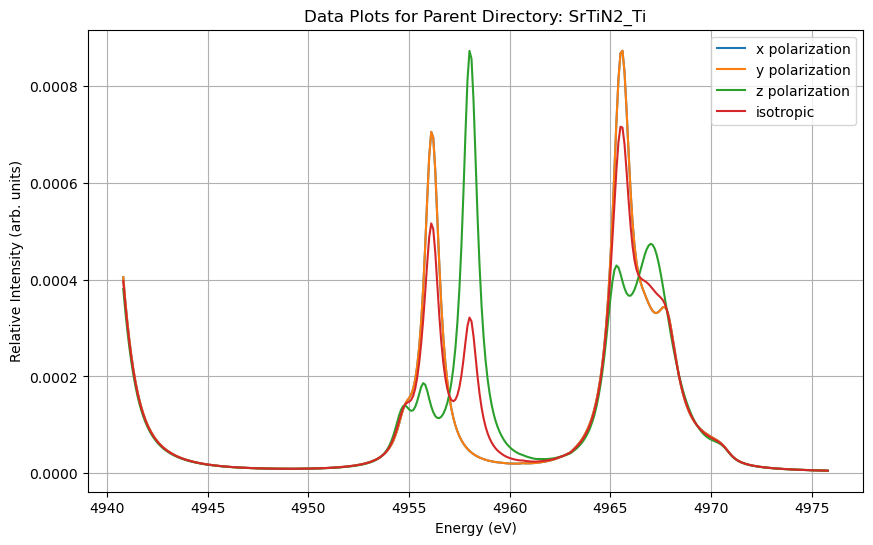

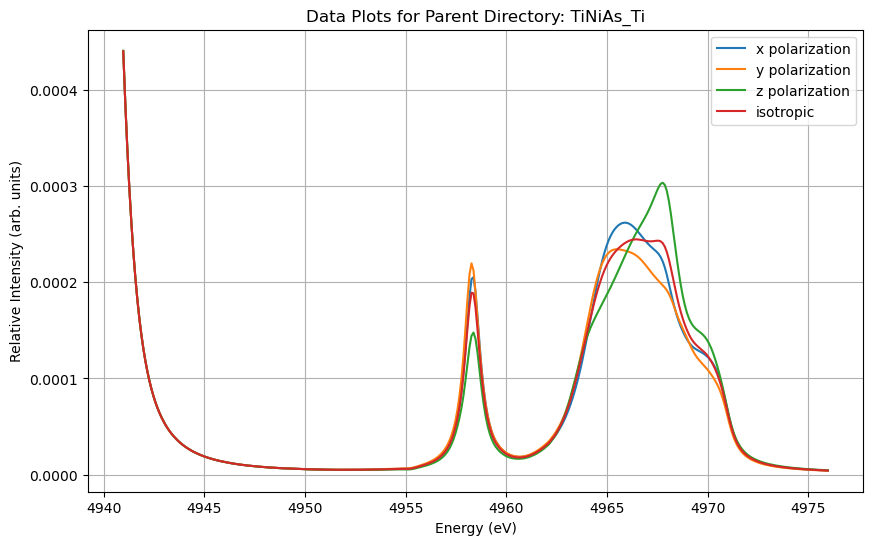

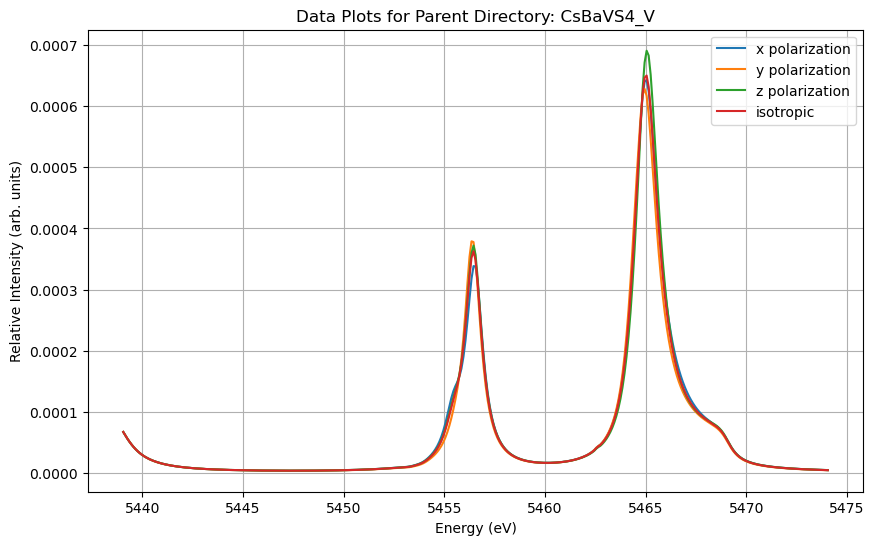

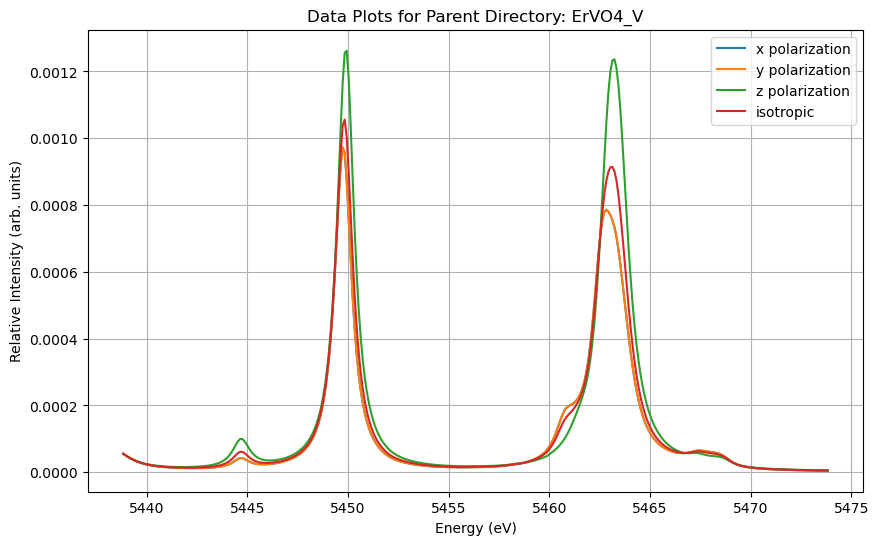

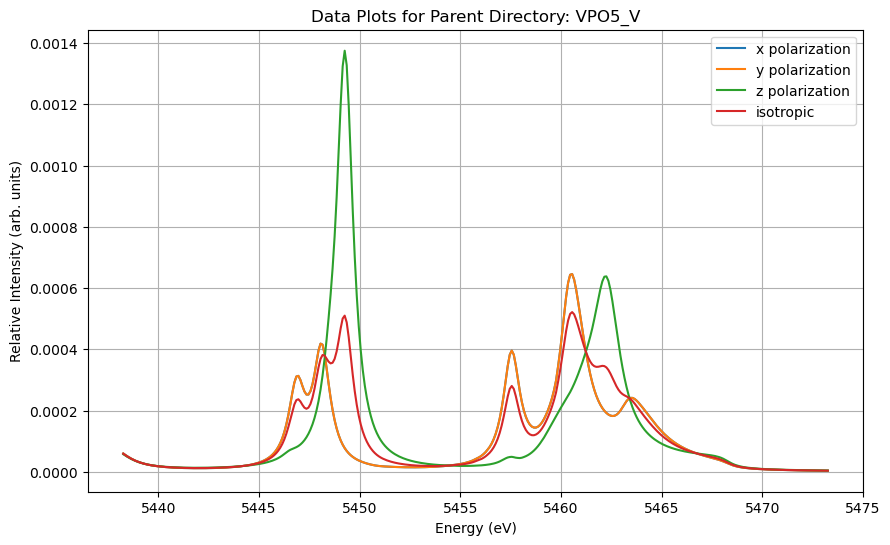

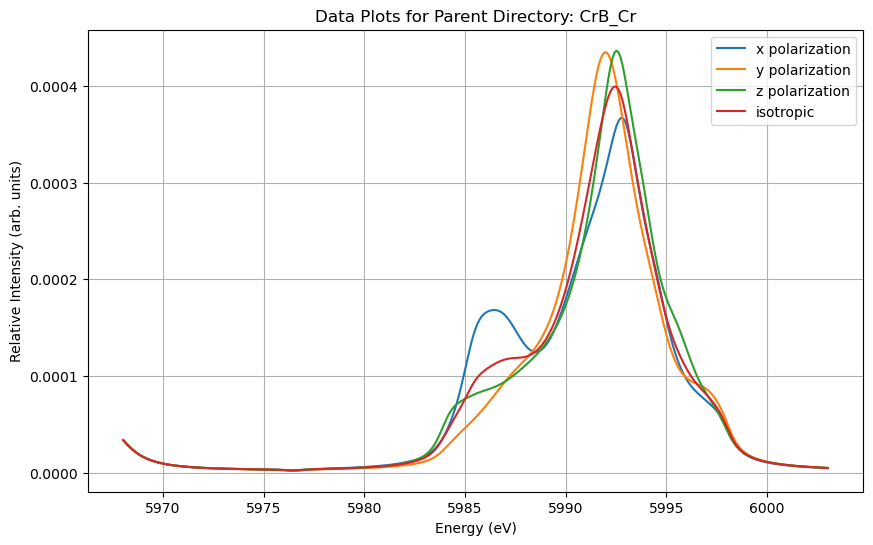

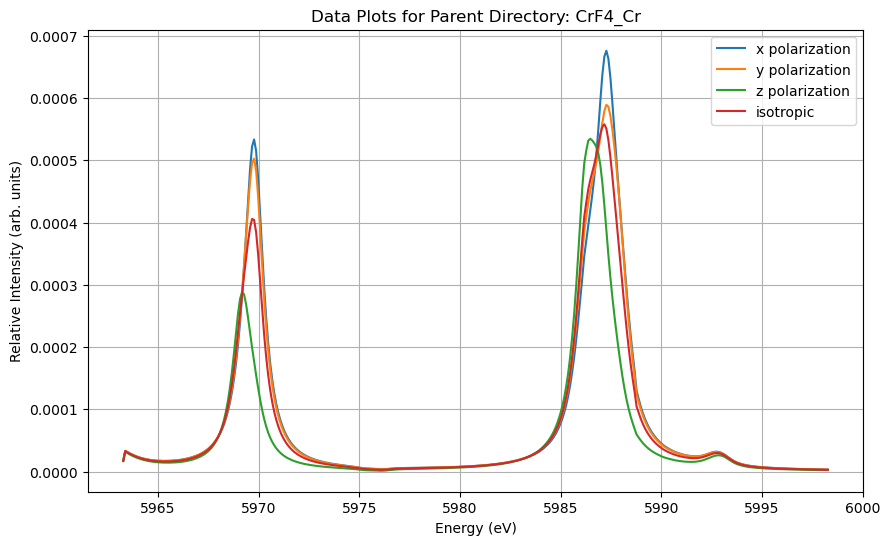

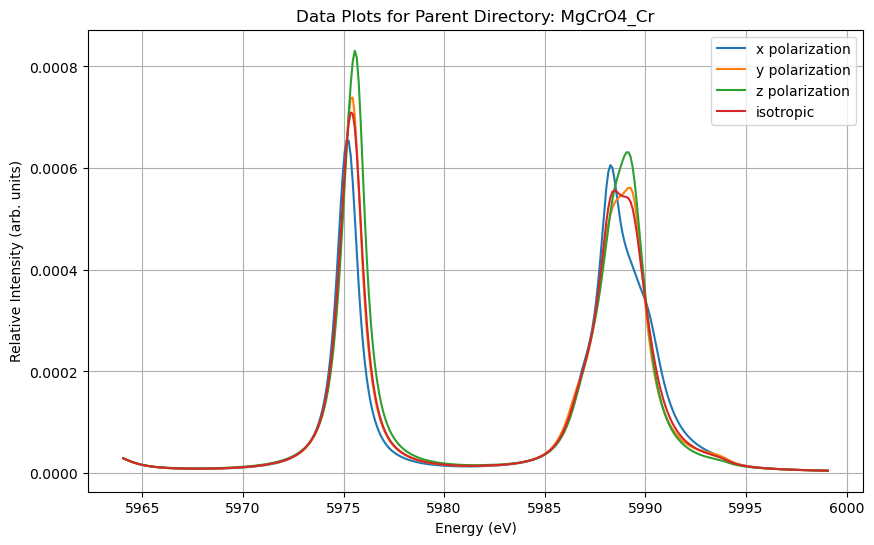

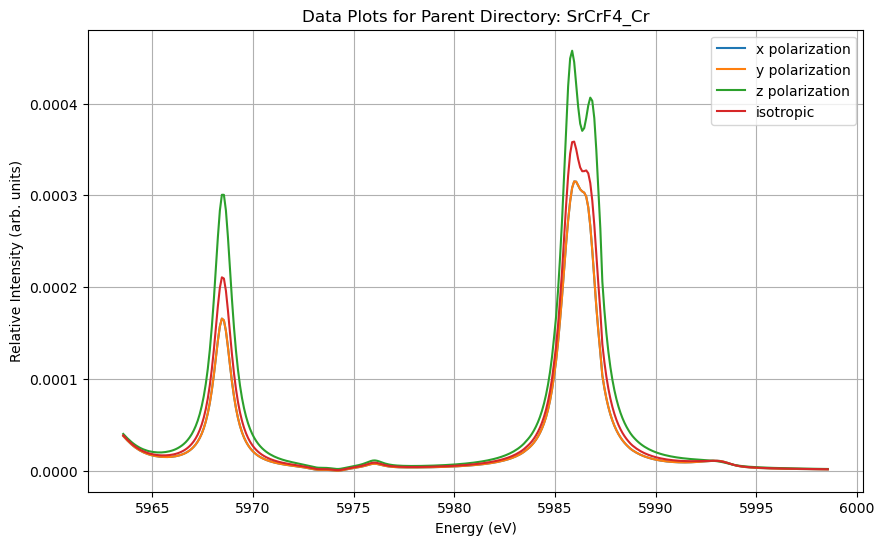

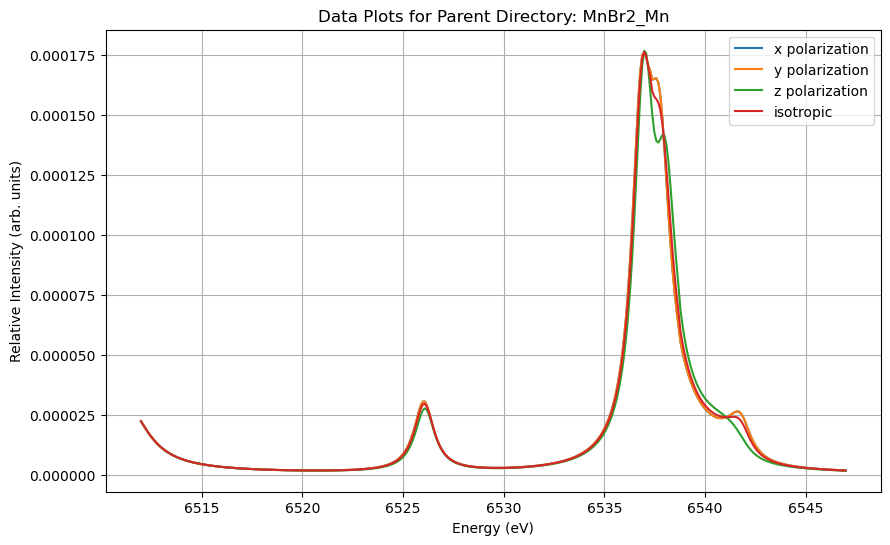

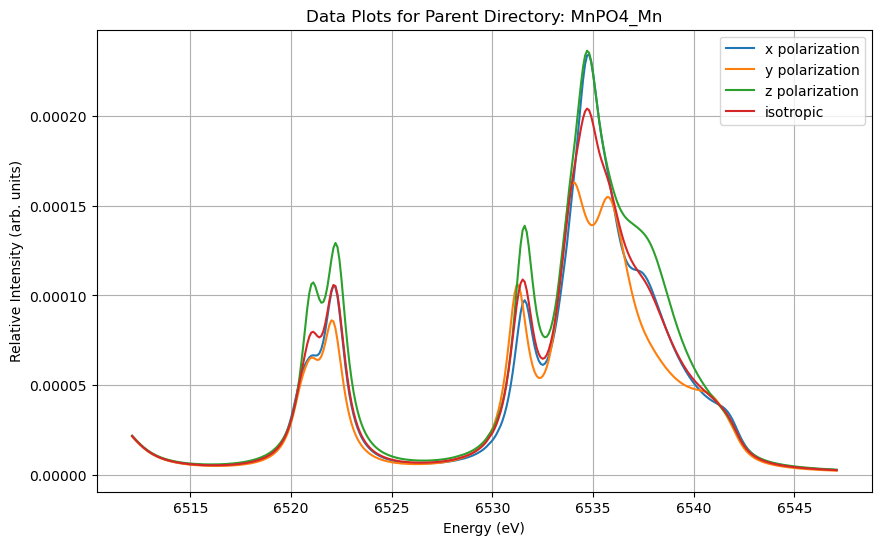

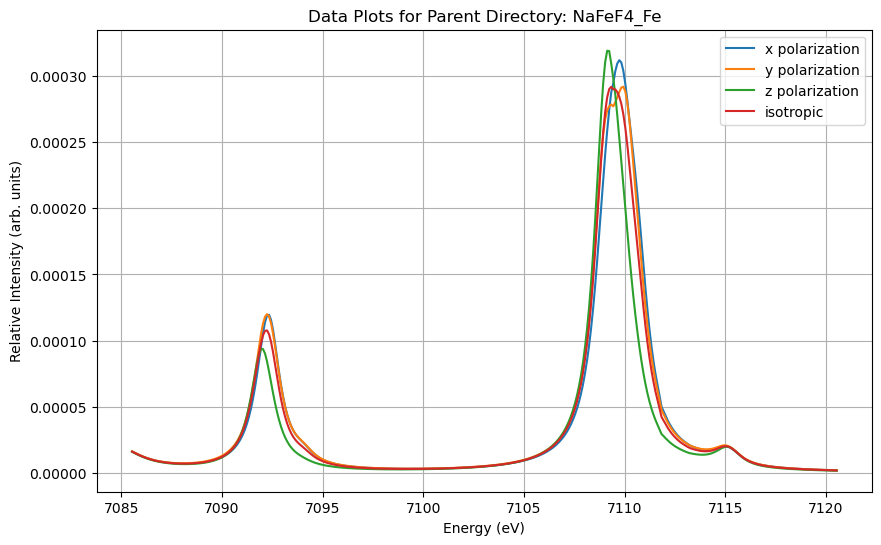

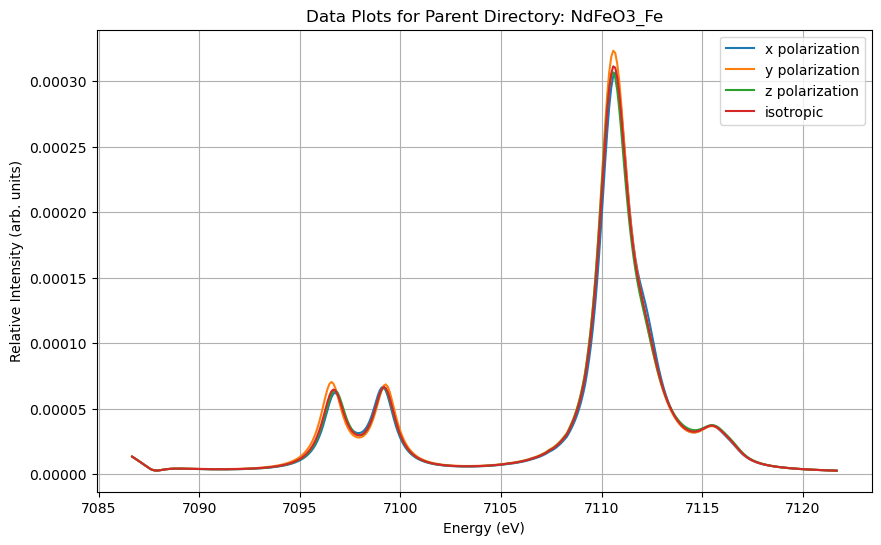

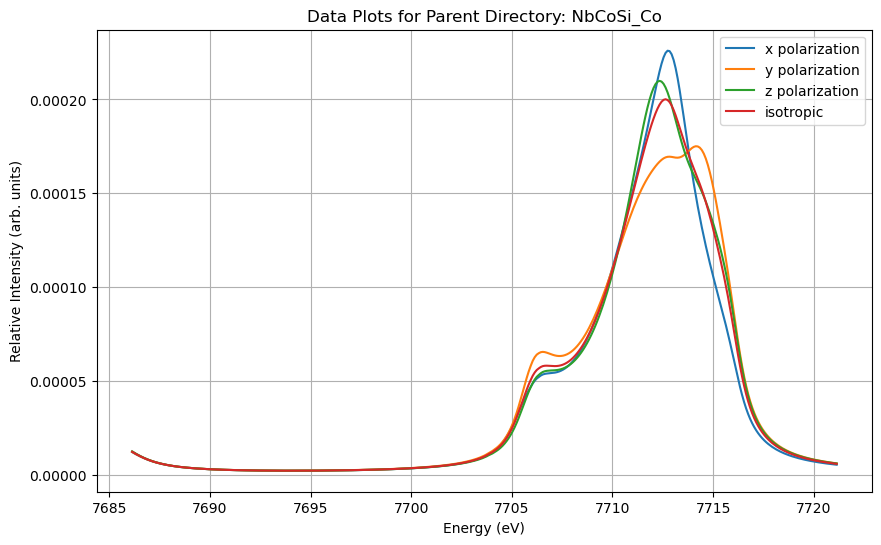

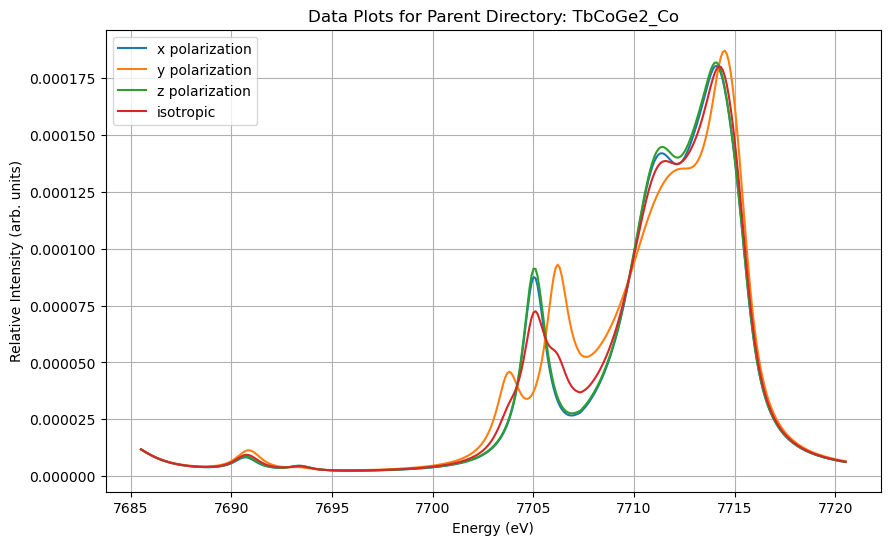

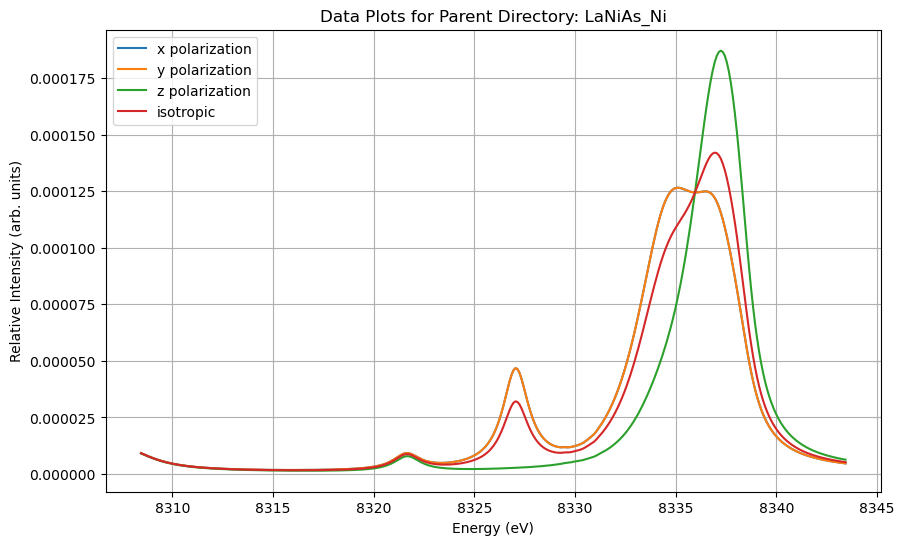

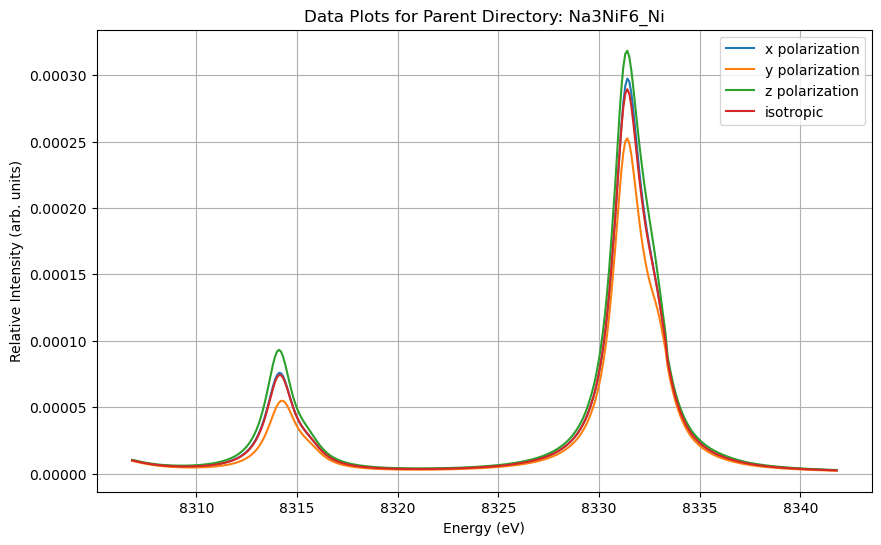

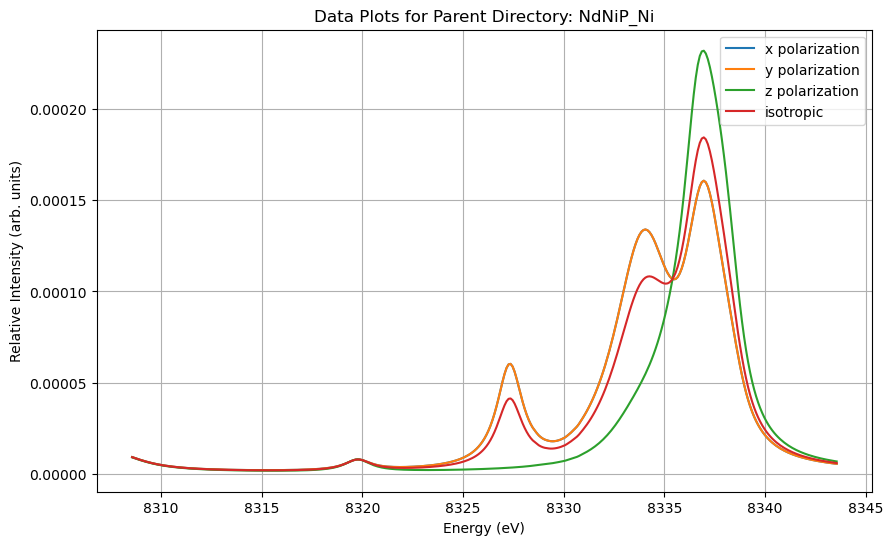

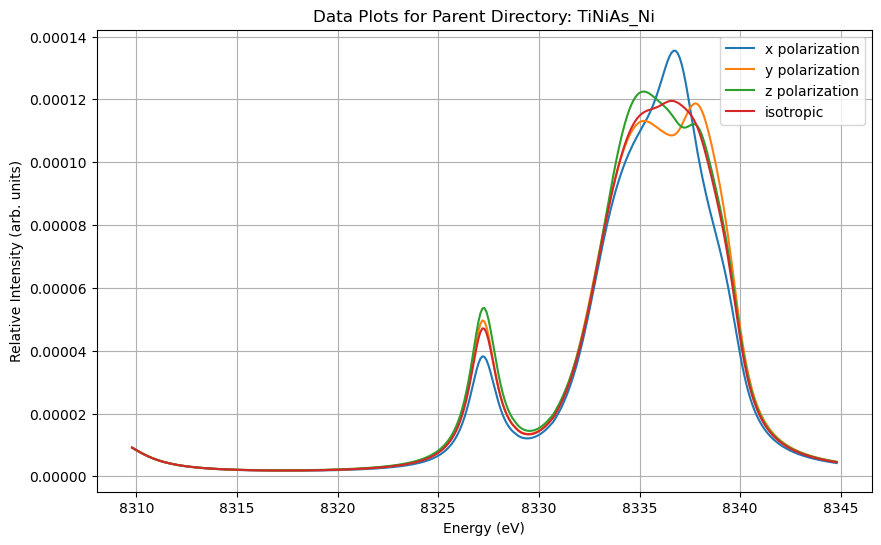

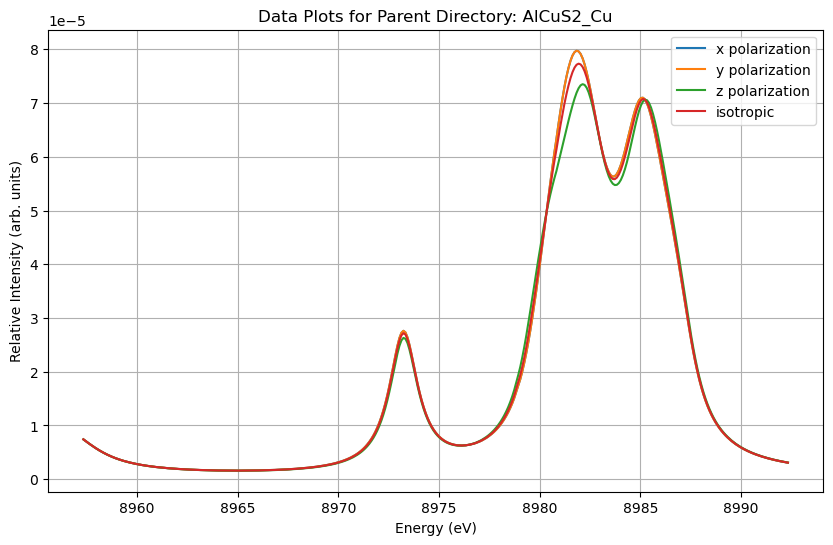

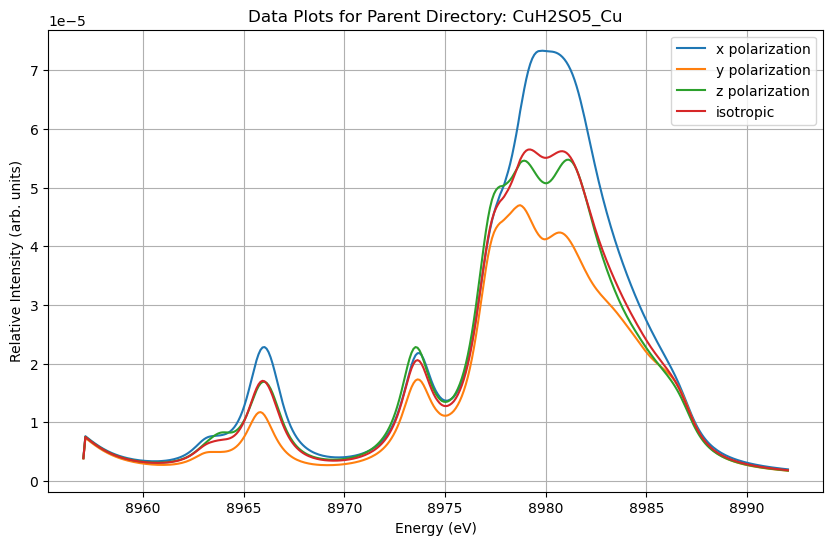

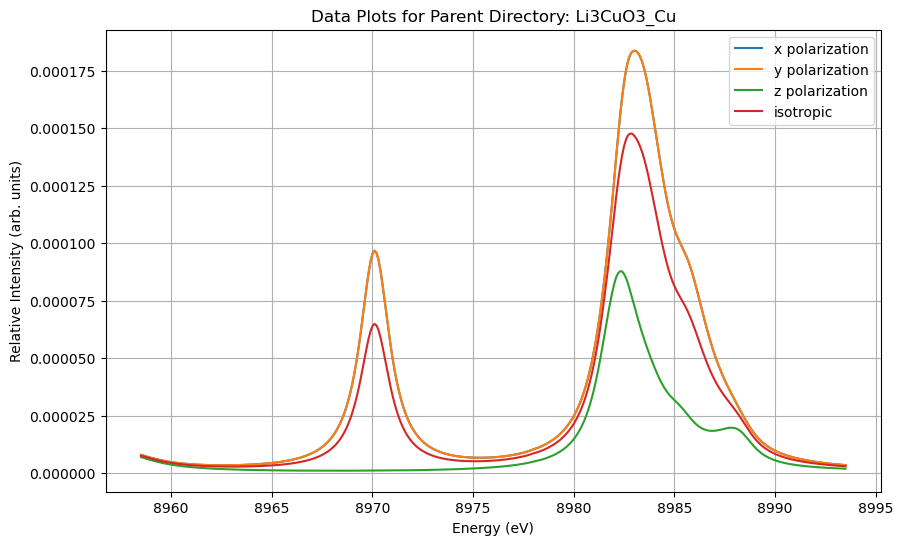

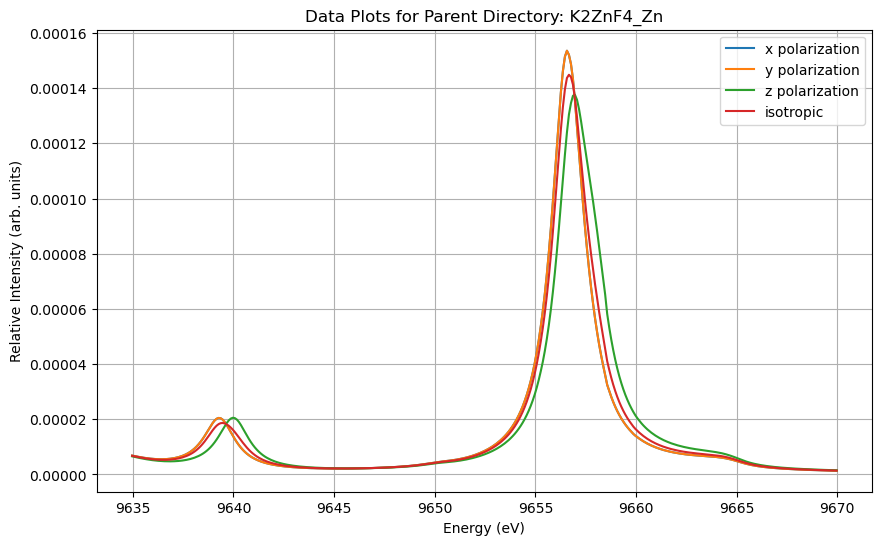

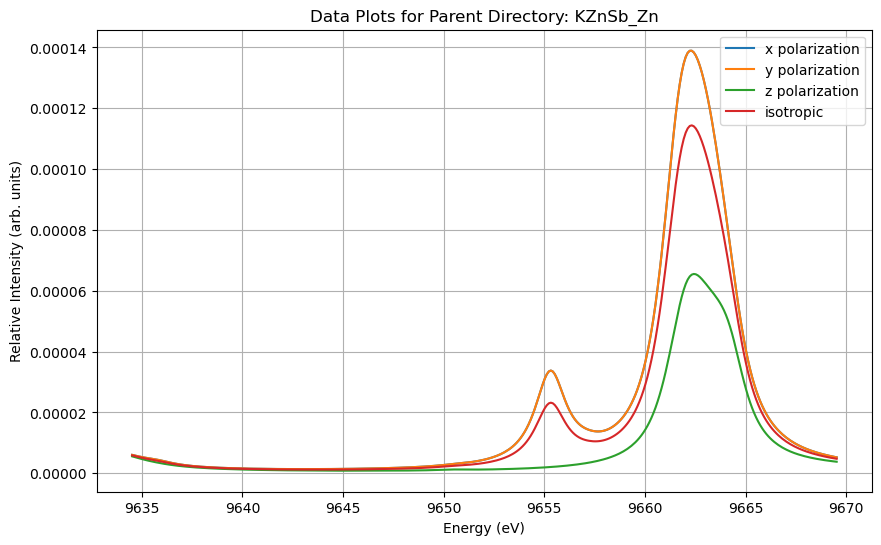

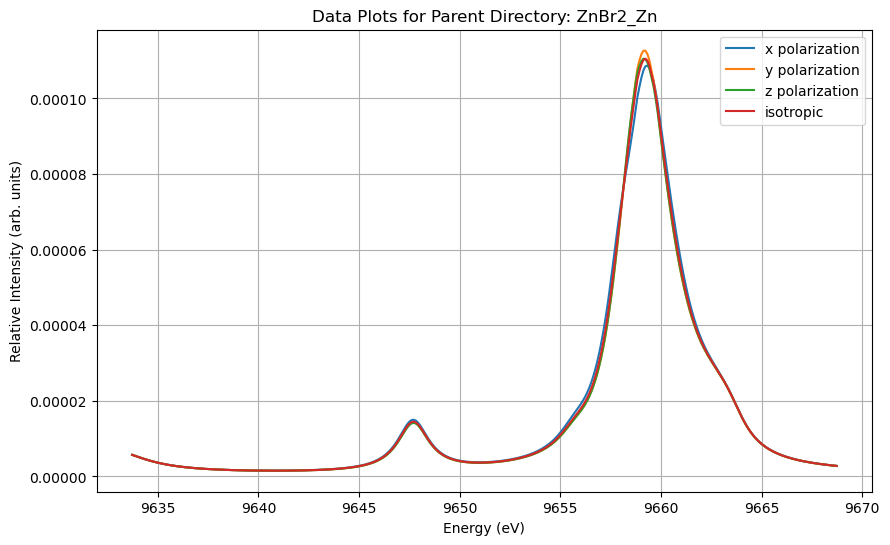

In [ ]:
file_groups = defaultdict(list)
for file in matching_files:
    # Extract the second-to-last directory (parent directory)
    parent_dir = os.path.basename(os.path.dirname(file))
    file_groups[parent_dir].append(file)

# Plot each group of files on the same plot
for parent_dir, files in file_groups.items():
    plt.figure(figsize=(10, 6))
    
    # Plot data for each file in the group
    for file in files:
        data = read_data(file)

        if data.shape[1] >= 4:
           
            plt.plot(data[:, 0], data[:, 1], label='x polarization')
            plt.plot(data[:, 0], data[:, 2], label='y polarization')
            plt.plot(data[:, 0], data[:, 3], label='z polarization')
            plt.plot(data[:, 0], data[:, 4], label='isotropic')
        else:
            print(f'File {file} does not have enough columns to plot all combinations.')

    plt.xlabel('Energy (eV)')
    plt.ylabel('Relative Intensity (arb. units)')
    plt.title(f'Data Plots for Parent Directory: {parent_dir}')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.show()